In [1]:
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML, Image
from ipywidgets import interact,Dropdown,IntSlider,FloatRangeSlider, FloatSlider, RadioButtons
rc('animation', html='html5')

In [18]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import h5py
import os
from tqdm import tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


In [3]:
cd /home/chenxupeng/projects/connectome/cluster/

/home/chenxupeng/projects/connectome/cluster


Task: visualize and understand the pattern of TP/FN/FP

Setup a html: visualize the middle slice of each example

Example html: [link] 

Try to find some patterns/clusters manually

fn/, fp/, tp/
data/: *.txt, list of folder ids

[k=0~4] Im_k.png: image, pd_k.png: synapse region, imPd_k.png: overlay image (for visualization) 

In [71]:
TPid = np.array(np.array([np.loadtxt('data/cerebellum/roi_label/data/tp_id.txt',dtype='str')])[0].split(','))

In [5]:
len([name for name in os.listdir('data/cerebellum/roi_label/tp/gt_122/')])

10

In [42]:
def read_patch(dirpath,ind,opt='gt'):
    '''
    dir:tp...
    ind:0,1,...
    opt gt/raw
    '''
    if opt=='gt':
        filepath ='data/cerebellum/roi_label/'+dirpath+'/gt_'+str(ind)+'/'
        filenum = int(len([name for name in os.listdir(filepath)]))
        #print (filepath)
        imgstackraw = {}
        imgstackmask = {}
        rawpath ={}
        maskpath = {}
        for i in range(int(filenum/2)):
            rawpath[i] =filepath+'im_'+str(i)+'.png'
            maskpath[i] = filepath+'pd_'+str(i)+'.png'
            imgstackraw[i] = scipy.misc.imread(filepath+'im_'+str(i)+'.png')
            imgstackmask[i] = scipy.misc.imread(filepath+'pd_'+str(i)+'.png')
        return imgstackraw,imgstackmask,rawpath,maskpath
    elif opt=='pred':
        filepath ='data/cerebellum/roi_label/'+dirpath+'/'+str(ind)+'/'
        filenum = int(len([name for name in os.listdir(filepath)]))
        imgstackraw = {}
        imgstackmask = {}
        imgstackoverlay = {}
        rawpath ={}
        maskpath = {}
        overlaypath = {}
        for i in range(int(filenum/3)):
            rawpath[i] =filepath+'im_'+str(i)+'.png'
            maskpath[i] = filepath+'pd_'+str(i)+'.png'
            overlaypath[i] = filepath+'imPd_'+str(i)+'.png'
            imgstackraw[i] = scipy.misc.imread(filepath+'im_'+str(i)+'.png')
            imgstackmask[i] = scipy.misc.imread(filepath+'pd_'+str(i)+'.png')
            imgstackoverlay[i] = scipy.misc.imread(filepath+'imPd_'+str(i)+'.png')
        return imgstackraw,imgstackmask,imgstackoverlay,rawpath,maskpath,overlaypath

In [7]:
read_patch('tp',10,opt='gt')[0][0].shape

data/cerebellum/roi_label/tp/gt_10/


(201, 201)

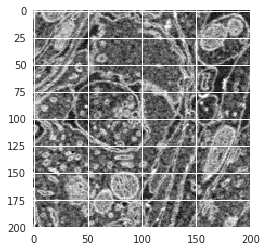

In [39]:
imshow(read_patch('tp',10,opt='gt')[0][0],cmap=cm.Greys)

data/cerebellum/roi_label/tp/gt_10/


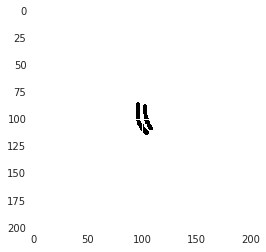

In [9]:
imshow(read_patch('tp',10,opt='gt')[1][0],cmap=cm.Greys)

In [34]:
def display_overlay(imgpath,maskpath,thres=0.3):
    background = Image.open(imgpath)
    overlay = Image.open(maskpath)
    background = background.convert("RGBA")
    overlay = overlay.convert("RGBA")
    return  Image.blend(background, overlay, thres)

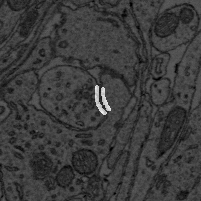

In [36]:
display_overlay(read_patch('tp',10,opt='gt')[2][0],read_patch('tp',10,opt='gt')[3][0],0.6)

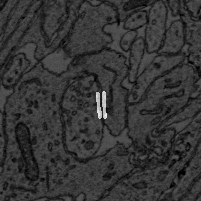

In [83]:
display_overlay(read_patch('tp',12,opt='gt')[2][0],read_patch('tp',12,opt='gt')[3][0],0.6)

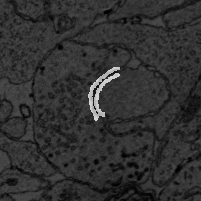

In [84]:
display_overlay(read_patch('tp',14,opt='gt')[2][0],read_patch('tp',14,opt='gt')[3][0],0.6)

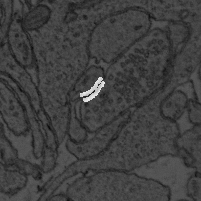

In [85]:
display_overlay(read_patch('tp',16,opt='gt')[2][0],read_patch('tp',16,opt='gt')[3][0],0.6)

In [82]:
for i in np.array([TPid[i].split('_')[1] for i in range(20)]).astype('int'):
    display_overlay(read_patch('tp',i,opt='gt')[2][0],read_patch('tp',i,opt='gt')[3][0],0.6)

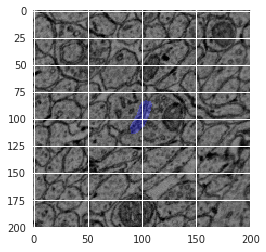

In [44]:
imshow(read_patch('tp',10,opt='pred')[2][0],cmap=cm.Greys)

## find the central point of clefts, use cremi as example

In [46]:
pwd

'/home/chenxupeng/projects/connectome/cluster'

In [47]:
import skimage
with h5py.File('../data/old/sample_A_padded_20160501.hdf','r') as f:
    rawA = f['volumes/raw'][:]
    cleftsA = f['volumes/labels/clefts'][:]
    neuronidA = f['volumes/labels/neuron_ids'][:]

In [48]:
def convert(data):
    data_ = np.copy(data)
    data_[np.where( data==18446744073709551615)] =0
    return data_

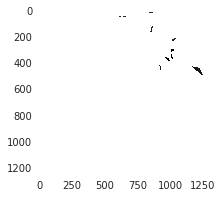

In [49]:
fig,ax = plt.subplots(1,figsize = (3,3))
ax.imshow(convert(cleftsA[0]),cmap=cm.Greys)

In [50]:
np.unique(convert(cleftsA[0]),return_counts=True)

(array([  0, 746, 754, 755, 756, 781, 788, 857, 858], dtype=uint64),
 array([1556765,     417,     602,     401,     422,     339,    1753,
            708,    1093]))

In [51]:
def calculate_range(data):
    uniqueseg = np.unique(convert(data))
    position = {}  # left,right,down,up
    for i in uniqueseg:
        if i !=0:
            xpos = np.where(data ==i)[0]
            ypos = np.where(data ==i)[1]
            position[i] = np.ndarray([4])
            down,up,lef,rig = np.min(xpos),np.max(xpos),np.min(ypos),np.max(ypos)
            position[i] = np.array([lef,rig,down,up])
    return position

In [52]:
dictest = calculate_range(convert(cleftsA[0]))

In [53]:
np.fromiter(dictest.keys(),dtype=int)

array([746, 754, 755, 756, 781, 788, 857, 858])

In [54]:
dictest[np.fromiter(dictest.keys(),dtype=int)[0]]

array([608, 661,  45,  56])

In [55]:
def get_central(pointdict):
    keys = np.fromiter(pointdict.keys(),dtype=int)
    central = np.ndarray([keys.shape[0],2])
    for i in range(keys.shape[0]):
        down,up,lef,rig = pointdict[keys[i]] 
        central[i] = np.array([(down+up)/2,(lef+rig)/2])
    return central

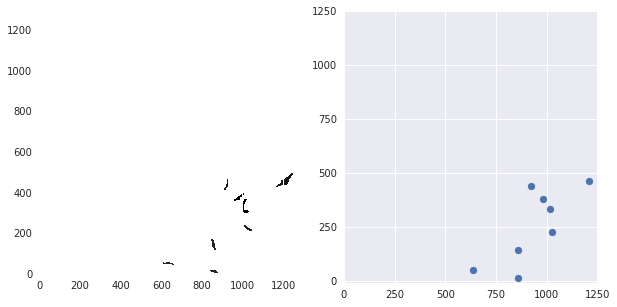

In [56]:
fig,ax = plt.subplots(1,2,figsize = (10,5))
ax[0].imshow(convert(cleftsA[0]) ,cmap=cm.Greys,origin='low')
ax[1].scatter(get_central(dictest)[:,0],get_central(dictest)[:,1],cmap=cm.Greys)
ax[1].set_xticks(np.arange(0,1500,250))
ax[1].set_yticks(np.arange(0,1500,250))